In [ ]:
import pandas as pd
import pdb
import re
import string
from sklearn.model_selection import train_test_split
from gensim import models
from keras.models import Sequential
from keras.models import Model
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import tensorflow as tf


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/DL_Final_Project_Akshada/

/content/drive/MyDrive/DL_Final_Project_Akshada


# **Data Preprocessing**

In [ ]:
dataset_final=pd.read_csv('FULL_Data_google_COVID_bull_bear.csv')

In [ ]:
dataset_final.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Open,High,Low,Close,Adj Close,Volume,MA7,MA21,MACD,20SD,upper_band,lower_band,EMA,logmomentum,absolute of 3 comp,angle of 3 comp,absolute of 6 comp,angle of 6 comp,absolute of 9 comp,angle of 9 comp,Date,search,COVID positiveIncrease,COVID deathIncrease,bull score,bear score,fourier bull 10,fourier bull 30,fourier bear 10,fourier bear 30
0,0,189,189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-07-01,17,0,0,0.000000,0.00,0.141086,0.147308,0.100437,0.101678
1,1,190,190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-07-02,17,0,0,0.200000,0.20,0.141930,0.147118,0.100488,0.100526
2,2,191,191,36.220001,36.325001,35.775002,35.875000,34.054882,57111200.0,36.173571,36.751904,0.303356,0.960520,38.672945,34.830864,35.924548,3.551770,38.458011,0.046984,29.704545,0.102857,43.304973,-0.053955,2017-07-03,15,0,0,0.666667,0.00,0.142778,0.146810,0.100537,0.099251
3,3,192,192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-07-04,15,0,0,0.000000,0.25,0.143631,0.146382,0.100585,0.097860
4,4,193,193,35.922501,36.197498,35.680000,36.022499,34.194897,86278400.0,36.095357,36.634762,0.328795,0.852735,38.340231,34.929292,35.989849,3.555991,38.240991,0.049445,29.954520,0.099254,43.438321,-0.053936,2017-07-05,15,0,0,0.400000,0.00,0.144487,0.145833,0.100630,0.096361


In [ ]:
# Set the date to datetime data
datetime_series = pd.to_datetime(dataset_final['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset_final = dataset_final.set_index(datetime_index)
dataset_final = dataset_final.sort_values(by='Date')
dataset_final = dataset_final.drop(columns='Date')

In [ ]:
#counting null values
print (dataset_final.isnull().sum())

Unnamed: 0                  0
Unnamed: 0.1                0
Open                      497
High                      497
Low                       497
Close                     497
Adj Close                 497
Volume                    497
MA7                       497
MA21                      497
MACD                      497
20SD                      497
upper_band                497
lower_band                497
EMA                       497
logmomentum               497
absolute of 3 comp        497
angle of 3 comp           497
absolute of 6 comp        497
angle of 6 comp           497
absolute of 9 comp        497
angle of 9 comp           497
search                      0
COVID positiveIncrease      0
COVID deathIncrease         0
bull score                 30
bear score                 30
fourier bull 10            30
fourier bull 30            30
fourier bear 10            30
fourier bear 30            30
dtype: int64


In [ ]:
dataset_final=dataset_final.dropna()

In [ ]:
#Dataframe will consist of financial data, fourier transformed features and google trends data
dataset_final=dataset_final.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','fourier bull 10','fourier bull 30','fourier bear 10','fourier bear 30','COVID positiveIncrease','COVID deathIncrease','bull score','bear score'], axis=1)

In [ ]:
corr_matrix = dataset_final.corr()
corr_matrix["Close"].sort_values(ascending=False)

Close                 1.000000
Adj Close             0.999969
EMA                   0.999888
Low                   0.999718
High                  0.999705
Open                  0.999450
MA7                   0.998479
MA21                  0.994688
upper_band            0.992889
lower_band            0.991553
absolute of 9 comp    0.990852
logmomentum           0.988380
absolute of 6 comp    0.980393
absolute of 3 comp    0.953602
20SD                  0.644094
search                0.372711
angle of 9 comp       0.016952
angle of 6 comp       0.005633
Volume               -0.162231
angle of 3 comp      -0.216991
MACD                 -0.345054
Name: Close, dtype: float64

In [ ]:
dataset_final.columns

Index(['Unnamed: 0.1.1.1', 'Open', 'High', 'Low', 'Close', 'Adj Close',
       'Volume', 'MA7', 'MA21', 'MACD', '20SD', 'upper_band', 'lower_band',
       'EMA', 'logmomentum', 'absolute of 3 comp', 'angle of 3 comp',
       'absolute of 6 comp', 'angle of 6 comp', 'absolute of 9 comp',
       'angle of 9 comp', 'search'],
      dtype='object')

In [ ]:
dataset_final.shape

(1080, 22)

### ***Generating training and test data***

In [ ]:
# Get features and target
X_value = pd.DataFrame(dataset_final.iloc[:, dataset_final.columns != "Close"])
y_value = pd.DataFrame(dataset_final.iloc[:, 3])

In [ ]:
y_value

,Low
2017-07-03,35.775002
2017-07-05,35.680000
2017-07-06,35.602501
2017-07-07,35.724998
2017-07-10,35.842499
...,...
2021-10-26,149.009995
2021-10-27,148.490005
2021-10-28,149.720001
2021-10-29,146.410004


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Normalized the data
X_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))
X_scaler.fit(X_value)
y_scaler.fit(y_value)

MinMaxScaler()

In [ ]:
X_scale_dataset = X_scaler.fit_transform(X_value)#shape 1080 X 21 - Consists of all features excluding the closing price
y_scale_dataset = y_scaler.fit_transform(y_value)#Shape 1080 X 1 - Consists of only the closing price

In [ ]:
y_scale_dataset.shape

(1080, 1)

In [ ]:
len(X_scale_dataset)

1080

In [ ]:
# Reshape the data
'''Set the data input steps and output steps, 
    we use 30 days data to predict 1 day price here, 
    reshape it to (None, input_step, number of features) used for LSTM input'''
n_steps_in = 3
n_features = X_value.shape[1]#21
n_steps_out = 1

# Get X/y dataset
def get_X_y(X_data, y_data):
    X = list()
    y = list()
    yc = list()

    length = len(X_data)#1080
    for i in range(0, length, 1):
        # pdb.set_trace()
        X_value = X_data[i: i + n_steps_in][:, :]
        y_value = y_data[i + n_steps_in: i + (n_steps_in + n_steps_out)][:, 0]
        yc_value = y_data[i: i + n_steps_in][:, :]
        if len(X_value) == 3 and len(y_value) == 1:
            X.append(X_value)#X will be a list of arrays of size 3 X 21 - features on previous 3 days
            y.append(y_value)#y will be a list of arrays of size 1 X 1 - next day
            yc.append(yc_value)#yc will be a list of arrays of size 3 X 1 - Closing price of the previous 3 days
    # pdb.set_trace()
    return np.array(X), np.array(y), np.array(yc)

In [ ]:
# get the train test predict index
def predict_index(dataset, X_train, n_steps_in, n_steps_out):
    # pdb.set_trace()
    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[n_steps_in : X_train.shape[0] + n_steps_in + n_steps_out - 1, :].index#dates starting from the 4th date in the original dataframe to the last date of the training set
    test_predict_index = dataset.iloc[X_train.shape[0] + n_steps_in:, :].index#dates starting from the 4th date from the end of the training data in the original dataframe to the last date in the original dataframe

    return train_predict_index, test_predict_index


In [ ]:
# Split train/test dataset
def split_train_test(data):
    
    train_size = round(len(X) * 0.7)
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [ ]:
# Get data and check shape
X, y, yc = get_X_y(X_scale_dataset, y_scale_dataset)#X will be of shape 1080 X 3 X 21 (each 3 X 21 array will be 3 days' worth of data). yc will have the corresponding closing price value
# pdb.set_trace()
X_train, X_test, = split_train_test(X)#X_train will be a 3d array consisting of 3 X 21 arrays , containing 70% of the original data and X_test will be a 3d array consisting of 3 X 25 arrays containing 30% of the original data
y_train, y_test, = split_train_test(y)#y_train will be a 3d array consisting of 1 X 1 arrays containing 70% of the original data and y_test will be a 3d array consisting of 1 X 1 arrays containing 30% of the original data
yc_train, yc_test, = split_train_test(yc)#yc_train will be a 3d array consisting of 3 X 1 arrays containing 70% of the original data and yc_test will be a 3d array consisting of 3 X 1 arrays containing 30% of the original data
index_train, index_test, = predict_index(dataset_final, X_train, n_steps_in, n_steps_out)

In [ ]:
# %% --------------------------------------- Printing the shape of the datasets -----------------------------------------------------------------
print('X shape: ', X.shape)
print('y shape: ', y.shape)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('y_c_train shape: ', yc_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)
print('y_c_test shape: ', yc_test.shape)
print('index_train shape:', index_train.shape)
print('index_test shape:', index_test.shape)


X shape:  (1077, 3, 21)
y shape:  (1077, 1)
X_train shape:  (754, 3, 21)
y_train shape:  (754, 1)
y_c_train shape:  (754, 3, 1)
X_test shape:  (323, 3, 21)
y_test shape:  (323, 1)
y_c_test shape:  (323, 3, 1)
index_train shape: (754,)
index_test shape: (323,)


### ***Training a GRU model***

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional
from tensorflow.keras.layers import BatchNormalization, Embedding, TimeDistributed, LeakyReLU
from tensorflow.keras.layers import GRU, LSTM
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from matplotlib import pyplot
from math import sqrt
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error

In [ ]:
LR = 0.0001
BATCH_SIZE = 20
N_EPOCH = 50

In [ ]:
input_dim = X_train.shape[1]#754
feature_size = X_train.shape[2]#21
output_dim = y_train.shape[1]#1

In [ ]:
X_train.shape

(754, 3, 21)

In [ ]:
def basic_GRU(input_dim, output_dim, feature_size) -> tf.keras.models.Model:
    model = Sequential()
    model.add(GRU(units=128, return_sequences = True, input_shape=(input_dim, feature_size)))  # 256, return_sequences = True
    # model.add(GRU(units=256, recurrent_dropout = 0.2)) #, return_sequences = True
    model.add(GRU(units=64, input_shape=(input_dim, feature_size)))
    #model.add(Dense(128))
    model.add(Dense(32))
    # model.add(Dense(32))
    model.add(Dense(units=output_dim))
    model.compile(optimizer=Adam(lr=LR), loss='mse',metrics=['mae'])
    history = model.fit(X_train, y_train, epochs=N_EPOCH, batch_size=BATCH_SIZE, validation_data=(X_test, y_test),
                        verbose=2, shuffle=False)
    # pdb.set_trace()
    aaa=[round(num,3) for num in history.history['loss']]
    bbb=[round(num,3) for num in history.history['val_loss']]
    pyplot.plot([x for x in range(0,50)],aaa, label='train')
    pyplot.plot([x for x in range(0,50)],bbb, label='validation')
    pyplot.legend()
    pyplot.show()

    return model

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
38/38 - 6s - loss: 9.2419e-04 - mae: 0.0241 - val_loss: 0.0226 - val_mae: 0.1403 - 6s/epoch - 149ms/step
Epoch 2/50
38/38 - 0s - loss: 0.0013 - mae: 0.0292 - val_loss: 0.0363 - val_mae: 0.1831 - 322ms/epoch - 8ms/step
Epoch 3/50
38/38 - 0s - loss: 9.9311e-04 - mae: 0.0268 - val_loss: 0.0107 - val_mae: 0.0919 - 330ms/epoch - 9ms/step
Epoch 4/50
38/38 - 0s - loss: 3.4998e-04 - mae: 0.0145 - val_loss: 0.0060 - val_mae: 0.0656 - 306ms/epoch - 8ms/step
Epoch 5/50
38/38 - 0s - loss: 2.6567e-04 - mae: 0.0125 - val_loss: 0.0067 - val_mae: 0.0708 - 317ms/epoch - 8ms/step
Epoch 6/50
38/38 - 0s - loss: 3.0668e-04 - mae: 0.0134 - val_loss: 0.0046 - val_mae: 0.0563 - 308ms/epoch - 8ms/step
Epoch 7/50
38/38 - 0s - loss: 3.3944e-04 - mae: 0.0141 - val_loss: 0.0037 - val_mae: 0.0500 - 309ms/epoch - 8ms/step
Epoch 8/50
38/38 - 0s - loss: 3.2311e-04 - mae: 0.0136 - val_loss: 0.0037 - val_mae: 0.0498 - 314ms/epoch - 8ms/step
Epoch 9/50
38/38 - 0s - loss: 2.6328e-04 - mae: 0.0122 - val_loss: 0.

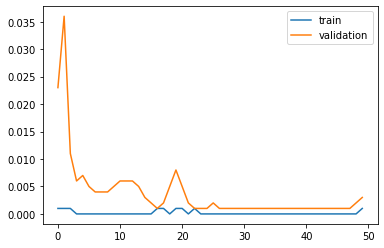

In [ ]:
model = basic_GRU(input_dim, output_dim, feature_size)
# print(model.summary())
# model.save('GRU_30to3.h5')

### ***Plotting the result***

### ***Train result***

In [ ]:
from sklearn.metrics import mean_absolute_error as mae

In [ ]:
def plot_realtraindataset_result(X_train,y_train):
  train_yhat=model.predict(X_train,verbose=0)#train_yhat will be the predicted values from 7 July 2017 to 20 July 2020
  # train_predict_index=np.load("index_train.npy",allow_pickle=True)
  # pdb.set_trace()
  rescaled_real_y=y_scaler.inverse_transform(y_train)#This will be the real closing price per day for train data from 7 July 2017 to 20 July 2020
  rescaled_predicted_y=y_scaler.inverse_transform(train_yhat)#This will be the predicted closing price per day for train data from 7 July 2017 to 20 July 2020

  predict_result=pd.DataFrame()

  for i in range(rescaled_predicted_y.shape[0]):#763
    y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=index_train[i:i + output_dim])
    predict_result=pd.concat([predict_result,y_predict],axis=1,sort=False)#This will be a dataframe with each column showing the predicted closing price for a single day 
  # pdb.set_trace()
  real_result=pd.DataFrame()

  for i in range(rescaled_real_y.shape[0]):
    y_real = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                                 index=index_train[i:i + output_dim])
    real_result=pd.concat([real_result,y_real],axis=1,sort=False)#This will be a dataframe with each column showing the real closing price for a single day 
  # pdb.set_trace()
  predict_result['predicted_mean'] = predict_result.mean(axis=1)#The last column of the dataframe will show the daily predicted closing price from 7 July 2017 to 20 July 2020
  real_result['real_mean'] = real_result.mean(axis=1)#The last column of the dataframe will show the daily real closing price from 7 July 2017 to 20 July 2020

  # Plot the predicted result
  plt.figure(figsize=(16, 8))
  plt.plot(real_result["real_mean"])
  plt.plot(predict_result["predicted_mean"], color='r')
  plt.xlabel("Date")
  plt.ylabel("Stock price")
  plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
  plt.title("The result of Train for GRU Model - With google trends data", fontsize=20)
  plt.show()

  # Calculate RMSE
  predicted = predict_result["predicted_mean"]
  real = real_result["real_mean"]
  For_MSE = pd.concat([predicted, real], axis=1)
  MSE = (mean_squared_error(predicted, real))
  RMSE = np.sqrt(mean_squared_error(predicted, real))
  MAE=mae(predicted, real)
  #print('-- Train RMSE -- ', RMSE)

  return MSE,RMSE,MAE

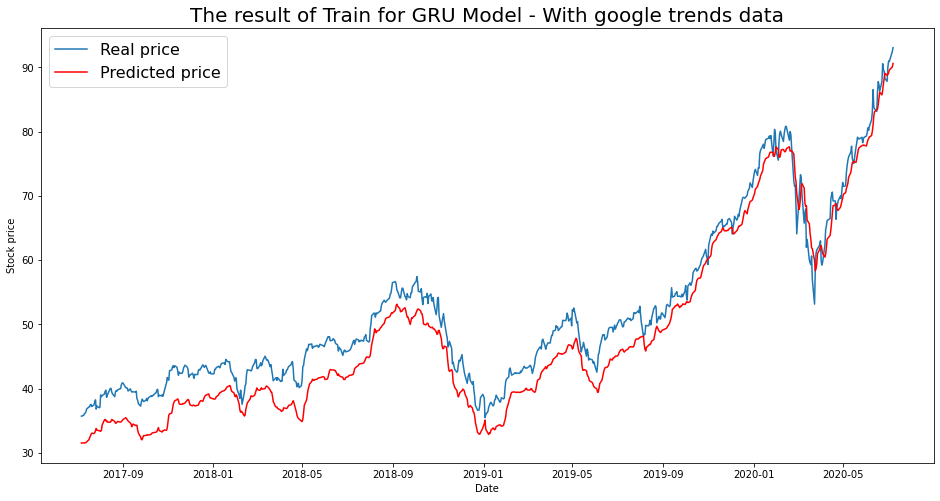

----- Train_MSE_LSTM ----- 15.859134585479072
----- Train_RMSE_LSTM ----- 3.9823528956483845
----- Train_mae_LSTM ----- 3.6821622122725026


In [ ]:
train_MSE,train_RMSE,train_MAE = plot_realtraindataset_result(X_train, y_train)
print("----- Train_MSE_LSTM -----", train_MSE)
print("----- Train_RMSE_LSTM -----", train_RMSE)
print("----- Train_mae_LSTM -----", train_MAE)

### ***Test result***

In [ ]:
def plot_testdataset_result(X_test, y_test):
    test_yhat = model.predict(X_test, verbose=0)
    # y_scaler = load(open('y_scaler.pkl', 'rb'))
    # test_predict_index = np.load("index_test.npy", allow_pickle=True)

    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(test_yhat)

    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=index_test[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):

        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=index_test[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)
    # pdb.set_trace()

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    # print(predict_result.tail(10))

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Testing GRU Model - With google trends data", fontsize=20)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    MSE = (mean_squared_error(predicted, real))
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    MAE=mae(predicted, real)

    return MSE,RMSE,MAE


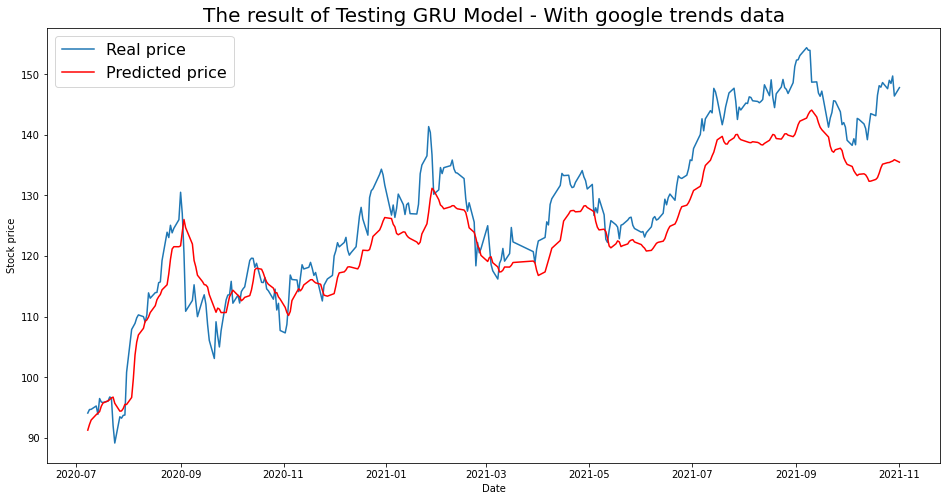

----- test_MSE_LSTM ----- 35.68007484700072
----- test_RMSE_LSTM ----- 5.973280074381304
----- test_MAE_LSTM ----- 5.01576891804887


In [ ]:
test_MSE,test_RMSE,test_MAE = plot_testdataset_result(X_test, y_test)
print("----- test_MSE_LSTM -----", test_MSE)
print("----- test_RMSE_LSTM -----", test_RMSE)
print("----- test_MAE_LSTM -----", test_MAE)

###***Analysis using baseline LSTM model***

In [ ]:
LR = 0.0001
BATCH_SIZE = 20
N_EPOCH = 147

In [ ]:
input_dim = X_train.shape[1]#3
feature_size = X_train.shape[2]#21
output_dim = y_train.shape[1]#1


### ***Defining the basic LSTM model***

In [ ]:
def basic_lstm(input_dim, feature_size):
    model = Sequential()
    model.add(LSTM(units= 64, input_shape=(input_dim, feature_size)))
    model.add(Dense(32))
    model.add(Dense(units=output_dim))
    model.compile(optimizer=Adam(lr = LR), loss='mse')
    history = model.fit(X_train, y_train, epochs=N_EPOCH, batch_size=BATCH_SIZE, validation_data=(X_test, y_test),
                        verbose=2, shuffle=False)

    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()

    return model

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/147
38/38 - 3s - loss: 0.0329 - val_loss: 0.3719 - 3s/epoch - 72ms/step
Epoch 2/147
38/38 - 0s - loss: 0.0075 - val_loss: 0.1650 - 203ms/epoch - 5ms/step
Epoch 3/147
38/38 - 0s - loss: 0.0065 - val_loss: 0.1034 - 212ms/epoch - 6ms/step
Epoch 4/147
38/38 - 0s - loss: 0.0044 - val_loss: 0.0667 - 193ms/epoch - 5ms/step
Epoch 5/147
38/38 - 0s - loss: 0.0029 - val_loss: 0.0418 - 175ms/epoch - 5ms/step
Epoch 6/147
38/38 - 0s - loss: 0.0019 - val_loss: 0.0265 - 185ms/epoch - 5ms/step
Epoch 7/147
38/38 - 0s - loss: 0.0013 - val_loss: 0.0175 - 177ms/epoch - 5ms/step
Epoch 8/147
38/38 - 0s - loss: 9.4300e-04 - val_loss: 0.0124 - 208ms/epoch - 5ms/step
Epoch 9/147
38/38 - 0s - loss: 6.9350e-04 - val_loss: 0.0095 - 172ms/epoch - 5ms/step
Epoch 10/147
38/38 - 0s - loss: 5.2822e-04 - val_loss: 0.0078 - 213ms/epoch - 6ms/step
Epoch 11/147
38/38 - 0s - loss: 4.1789e-04 - val_loss: 0.0068 - 164ms/epoch - 4ms/step
Epoch 12/147
38/38 - 0s - loss: 3.4451e-04 - val_loss: 0.0061 - 168ms/epoch - 4ms/

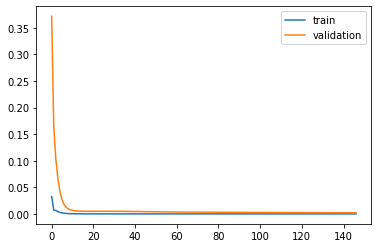

In [ ]:
model = basic_lstm(input_dim, feature_size)

In [ ]:
# model.save('LSTM_3to1.h5')
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                22016     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 24,129
Trainable params: 24,129
Non-trainable params: 0
_________________________________________________________________
None


### ***Plot train result***

In [ ]:
def plot_traindataset_result(X_train, y_train):


    train_yhat = model.predict(X_train, verbose=0)#Predicted (scaled) closing price for train set. Of size 157 X 1

    rescaled_real_y = y_scaler.inverse_transform(y_train)#Real closing price data
    rescaled_predicted_y = y_scaler.inverse_transform(train_yhat)#Predicted closing price data

    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=index_train[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)#This is a dataframe with each column containing the predicted daily closing price of the 4th day
    # pdb.set_trace()
    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=index_train[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)#This is a dataframe with each column containing the real daily closing price
    # pdb.set_trace()
    predict_result['predicted_mean'] = predict_result.mean(axis=1)#Adding a column with the daily predicted closing price value
    real_price['real_mean'] = real_price.mean(axis=1)#Adding a column with the daily real closing price value
    #
    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Training LSTM Model - With google trends data", fontsize=20)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    MSE = (mean_squared_error(predicted, real))
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    MAE=mae(predicted, real)
    #print('-- Train RMSE -- ', RMSE)

    return MSE,RMSE,MAE

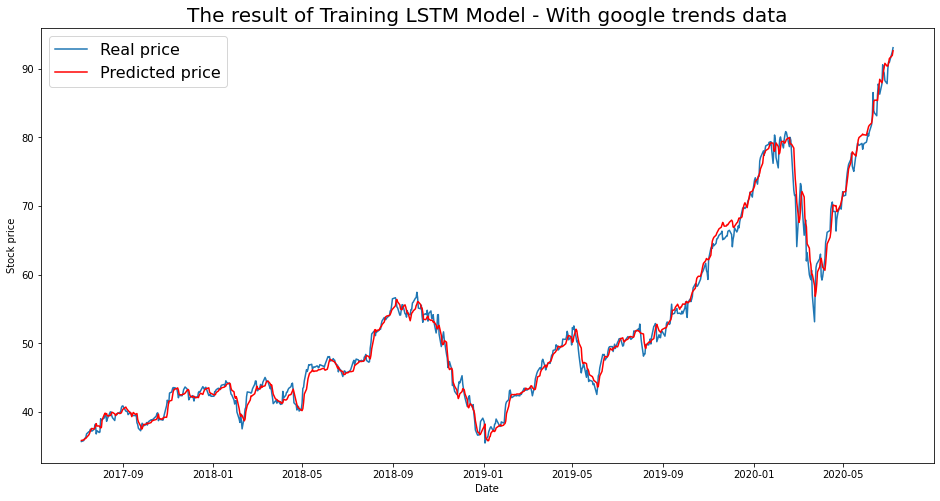

----- Train_MSE_LSTM ----- 1.4151273930889712
----- Train_RMSE_LSTM ----- 1.1895912714411496
----- Train_MAE_LSTM ----- 0.8483387807011692


In [ ]:
train_MSE,train_RMSE,train_MAE = plot_traindataset_result(X_train, y_train)
print("----- Train_MSE_LSTM -----", train_MSE)
print("----- Train_RMSE_LSTM -----", train_RMSE)
print("----- Train_MAE_LSTM -----", train_MAE)

### ***Plot test result***

In [ ]:
def plot_testdataset_result(X_test, y_test):

    test_yhat = model.predict(X_test, verbose=0)
    # y_scaler = load(open('y_scaler.pkl', 'rb'))
    # test_predict_index = np.load("index_test.npy", allow_pickle=True)

    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(test_yhat)

    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=index_test[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=index_test[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    # print(predict_result.tail(10))

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Testing LSTM Model - With google trends data", fontsize=20)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    MSE = (mean_squared_error(predicted, real))
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    MAE=mae(predicted, real)

    return MSE,RMSE,MAE


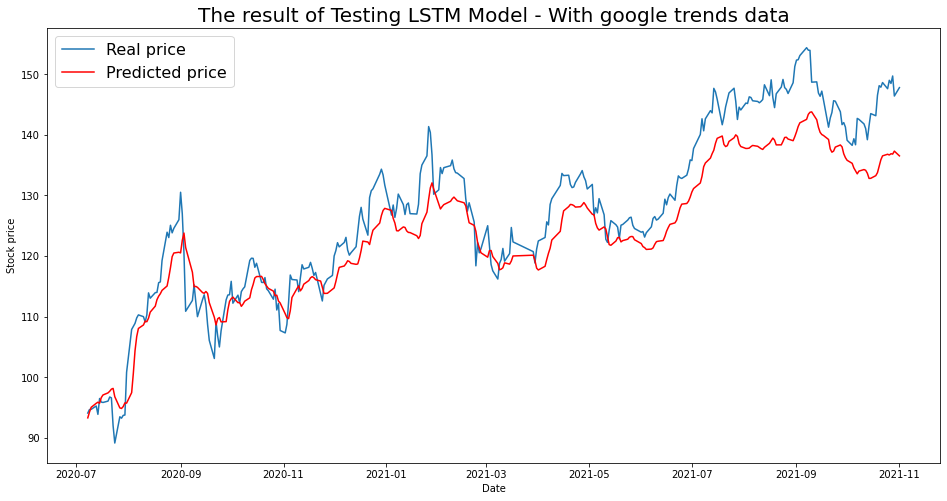

----- test_MSE_LSTM ----- 31.425486519060087
----- test_RMSE_LSTM ----- 5.605843961354979
----- test_MAE_LSTM ----- 4.66257705914401


In [ ]:
# test_RMSE = plot_testdataset_result(X_test, y_test)
test_MSE,test_RMSE,test_MAE = plot_testdataset_result(X_test, y_test)
print("----- test_MSE_LSTM -----", test_MSE)
print("----- test_RMSE_LSTM -----", test_RMSE)
print("----- test_MAE_LSTM -----", test_MAE)

### ***Implementing basic GAN***

In [ ]:
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
import os

In [ ]:
def make_generator_model(input_dim, output_dim, feature_size) -> tf.keras.models.Model:

    model = Sequential()
    model.add(GRU(units=1024, return_sequences = True, input_shape=(input_dim, feature_size),
                  recurrent_dropout=0.2))
    model.add(GRU(units=512, return_sequences = True, recurrent_dropout=0.2)) # 256, return_sequences = True
    model.add(GRU(units=256, recurrent_dropout=0.2)) #, recurrent_dropout=0.1
    # , recurrent_dropout = 0.2
    model.add(Dense(128))
    # model.add(Dense(128))
    model.add(Dense(64))
    #model.add(Dense(16))
    model.add(Dense(units=output_dim))
    return model

In [ ]:
def make_discriminator_model():

    cnn_net = tf.keras.Sequential()
    cnn_net.add(Conv1D(32, input_shape=(4, 1), kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(64, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(128, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Flatten())
    cnn_net.add(Dense(220, use_bias=False))
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False, activation='relu'))
    cnn_net.add(Dense(1, activation='sigmoid'))
    return cnn_net

In [ ]:
model = make_discriminator_model()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 32)             128       
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             10304     
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 128)            41088     
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 220)               28160     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 220)               0         
                                                                 
 dense_5 (Dense)             (None, 220)              

### ***GAN Class***

In [ ]:
class GAN:
    def __init__(self, generator, discriminator, opt):
        # pdb.set_trace()

        self.opt = opt
        self.lr = opt["lr"]
        self.generator = generator
        self.discriminator = discriminator
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.generator_optimizer = tf.keras.optimizers.Adam(lr=self.lr)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(lr=self.lr)
        self.batch_size = self.opt['bs']


    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return real_loss, fake_loss, total_loss

    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    @tf.function
    def train_step(self, real_x, real_y, yc):#Generating real price, fake price and loss
        # pdb.set_trace()

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # pdb.set_trace()
            z=tf.random.normal([real_x.shape[0]*real_x.shape[1]*(real_x.shape[2]-1)])
            z_reshape = tf.reshape(z, [real_x.shape[0],real_x.shape[1],(real_x.shape[2]-1)])#new shape will be 754 X 3 X 20
            z_reshape= tf.cast(z_reshape, tf.float64)
            gen_input = tf.concat([z_reshape, yc], axis=2)#shape will be 754 X 3 X 21
            generated_data = self.generator(gen_input, training=True)#shape will be 754 X 1
            generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])#new shape will be 754 X 1 X 1
            d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)#shape will be 754 X 4 X 1
            real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
            # pdb.set_trace()
            d_real_input = tf.concat([real_y_reshape, yc], axis=1)

            real_output = self.discriminator(d_real_input, training=True)#shape 754 X 1
            fake_output = self.discriminator(d_fake_input, training=True)#shape 754 X 1

            gen_loss = self.generator_loss(fake_output)
            disc_loss_real,disc_loss_fake,disc_loss = self.discriminator_loss(real_output, fake_output)
        # pdb.set_trace()
        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(
            zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        # pdb.set_trace()
        return real_y, generated_data, {'d_loss_real': disc_loss_real, 'd_loss_fake': disc_loss_fake, 'g_loss': gen_loss}

    @tf.function
    def test_step(self, real_x, real_y, yc):
        # pdb.set_trace()
        z=tf.random.normal([real_x.shape[0]*real_x.shape[1]*(real_x.shape[2]-1)])
        z_reshape = tf.reshape(z, [real_x.shape[0],real_x.shape[1],(real_x.shape[2]-1)])#new shape will be 754 X 3 X 20
        z_reshape= tf.cast(z_reshape, tf.float64)
        gen_input = tf.concat([z_reshape, yc], axis=2)#shape will be 754 X 3 X 21
        generated_data = self.generator(gen_input)
        generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
        d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)
        real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
        d_real_input = tf.concat([real_y_reshape, yc], axis=1)

        real_output = self.discriminator(d_real_input, training=True)
        fake_output = self.discriminator(d_fake_input, training=True)

        gen_loss = self.generator_loss(fake_output)
        disc_loss_real,disc_loss_fake,disc_loss = self.discriminator_loss(real_output, fake_output)

        return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': gen_loss}


    def train(self, real_x, real_y, yc, opt):

        train_hist = {}
        train_hist['D_real_losses'] = []
        train_hist['D_fake_losses'] = []
        train_hist['G_losses'] = []
        train_hist['per_epoch_times'] = []
        train_hist['total_ptime'] = []

        epochs = opt["epoch"]
        for epoch in range(epochs):#At the end of the for loop, we will get
        #D_losses : list of n=epochs elements with each element = disc loss
        #G_losses : list of n=epochs elements with each element = generator loss
        #Predicted_price : list of n=epochs elements with each element of size 754 X 1

            start = time.time()

            real_price, fake_price, loss = self.train_step(real_x, real_y, yc)

            G_losses = []
            D_real_losses = []
            D_fake_losses = []

            Real_price = []
            Predicted_price = []

            D_real_losses.append(loss['d_loss_real'].numpy())
            D_fake_losses.append(loss['d_loss_fake'].numpy())
            G_losses.append(loss['g_loss'].numpy())

            Predicted_price.append(fake_price.numpy())
            Real_price.append(real_price.numpy())

            # Save the model every 15 epochs
            if (epoch + 1) % 15 == 0:

                print('epoch', epoch + 1, 'd_loss_real', loss['d_loss_real'].numpy(), 'g_loss', loss['g_loss'].numpy())
            # For printing loss
            epoch_end_time = time.time()
            per_epoch_ptime = epoch_end_time - start
            train_hist['D_real_losses'].append(D_real_losses)
            train_hist['D_fake_losses'].append(D_fake_losses)
            train_hist['G_losses'].append(G_losses)
            train_hist['per_epoch_times'].append(per_epoch_ptime)

        # Reshape the predicted result & real
        Predicted_price = np.array(Predicted_price)
        Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
        Real_price = np.array(Real_price)
        Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

        plt.plot(train_hist['D_real_losses'], label='D_loss_real')
        plt.plot(train_hist['D_fake_losses'], label='D_loss_fake')
        plt.plot(train_hist['G_losses'], label='G_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        # pdb.set_trace()
        return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(
            Real_price)


    def test(self, real_x, real_y, yc, opt):
        # pdb.set_trace()


        real_price, fake_price, loss = self.test_step(real_x, real_y, yc)

        G_losses = []
        D_losses = []

        Real_price = []
        Predicted_price = []
        # pdb.set_trace()
        D_losses.append(loss['d_loss'].numpy())
        G_losses.append(loss['g_loss'].numpy())

        Predicted_price.append(fake_price.numpy())
        Real_price.append(real_price.numpy())


        # Reshape the predicted result & real
        Predicted_price = np.array(Predicted_price)
        Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
        Real_price = np.array(Real_price)
        Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])


        return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(
            Real_price)


In [ ]:
import time


In [ ]:
y_train.shape


(754, 1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


epoch 15 d_loss_real 0.6913027 g_loss 0.69153005
epoch 30 d_loss_real 0.69193065 g_loss 0.69541806
epoch 45 d_loss_real 0.69363904 g_loss 0.6937036
epoch 60 d_loss_real 0.69156474 g_loss 0.6933329
epoch 75 d_loss_real 0.6909426 g_loss 0.69138515
epoch 90 d_loss_real 0.69303 g_loss 0.6949278
epoch 105 d_loss_real 0.6930207 g_loss 0.6947211
epoch 120 d_loss_real 0.69208765 g_loss 0.6921299
epoch 135 d_loss_real 0.69281644 g_loss 0.6929662
epoch 150 d_loss_real 0.6933679 g_loss 0.69339675
epoch 165 d_loss_real 0.69326425 g_loss 0.6932344
epoch 180 d_loss_real 0.6931927 g_loss 0.69315046
epoch 195 d_loss_real 0.69325966 g_loss 0.69323325
epoch 210 d_loss_real 0.69315404 g_loss 0.693111
epoch 225 d_loss_real 0.6931132 g_loss 0.6930495
epoch 240 d_loss_real 0.6931887 g_loss 0.6931333


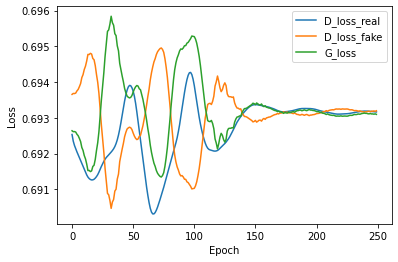

In [ ]:
if __name__ == '__main__':
    input_dim = X_train.shape[1]#3
    feature_size = X_train.shape[2]#21
    output_dim = y_train.shape[1]#1

    ## For Bayesian
    opt = {"lr": 0.0001, "epoch": 250, 'bs': 20}

    generator = make_generator_model(X_train.shape[1], output_dim, X_train.shape[2])
    discriminator = make_discriminator_model()
    gan = GAN(generator, discriminator, opt)
    Predicted_price, Real_price, RMSPE = gan.train(X_train, y_train, yc_train, opt)




----- predicted price ----- [[ 0.0062258 ]
 [ 0.00293578]
 [-0.00908001]
 [ 0.01269941]
 [ 0.00951299]
 [ 0.00357406]
 [ 0.00182034]
 [ 0.0191427 ]
 [ 0.01195705]
 [ 0.01715943]
 [ 0.01433702]
 [ 0.01735104]
 [ 0.01112623]
 [ 0.02134862]
 [ 0.02204091]
 [ 0.02070248]
 [ 0.00660648]
 [ 0.01618334]
 [ 0.01046099]
 [ 0.01807865]
 [ 0.02201439]
 [ 0.03081411]
 [ 0.03548692]
 [ 0.03742992]
 [ 0.03188782]
 [ 0.03269372]
 [ 0.02369262]
 [ 0.03665499]
 [ 0.03083214]
 [ 0.0344389 ]
 [ 0.04207212]
 [ 0.03687306]
 [ 0.03279561]
 [ 0.02816016]
 [ 0.03394287]
 [ 0.03404688]
 [ 0.04331865]
 [ 0.04254642]
 [ 0.04350582]
 [ 0.03492444]
 [ 0.04055231]
 [ 0.04318575]
 [ 0.04349934]
 [ 0.03013067]
 [ 0.03575113]
 [ 0.03210872]
 [ 0.03707055]
 [ 0.03960802]
 [ 0.04415878]
 [ 0.03101948]
 [ 0.03302949]
 [ 0.03450298]
 [ 0.03268388]
 [ 0.02975881]
 [ 0.01652992]
 [ 0.01534063]
 [ 0.01704942]
 [ 0.01535107]
 [ 0.00582879]
 [ 0.03155934]
 [ 0.01544835]
 [ 0.01928504]
 [ 0.02069951]
 [ 0.02664397]
 [ 0.0207487

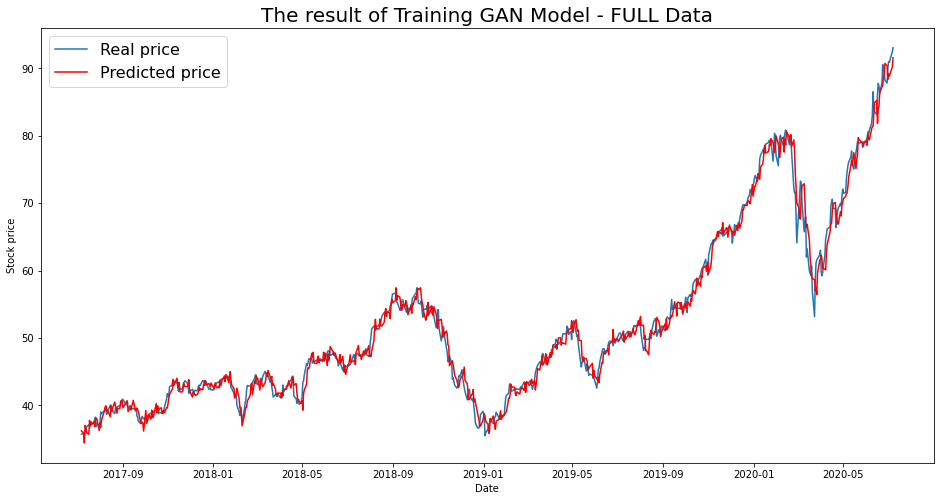

----- Train_MSE_GAN ----- 2.0924023490394017
----- Train_RMSE_GAN ----- 1.446513860645449
----- Train_MAE_GAN ----- 1.0571661002423922


In [ ]:
train_predict_index = np.load("index_train.npy", allow_pickle=True)
test_predict_index = np.load("index_test.npy", allow_pickle=True)


print("----- predicted price -----", Predicted_price)

rescaled_Real_price = y_scaler.inverse_transform(Real_price)
rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

print("----- rescaled predicted price -----", rescaled_Predicted_price)
print("----- SHAPE rescaled predicted price -----", rescaled_Predicted_price.shape)

predict_result = pd.DataFrame()
for i in range(rescaled_Predicted_price.shape[0]):
    y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=index_train[i:i+output_dim])
    predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)
#
real_price = pd.DataFrame()
for i in range(rescaled_Real_price.shape[0]):
    y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=index_train[i:i+output_dim])
    real_price = pd.concat([real_price, y_train], axis=1, sort=False)

predict_result['predicted_mean'] = predict_result.mean(axis=1)
real_price['real_mean'] = real_price.mean(axis=1)

# Plot the predicted result
plt.figure(figsize=(16, 8))
plt.plot(real_price["real_mean"])
plt.plot(predict_result["predicted_mean"], color = 'r')
plt.xlabel("Date")
plt.ylabel("Stock price")
plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
plt.title("The result of Training GAN Model - FULL Data", fontsize=20)
plt.show()

# Calculate RMSE
predicted = predict_result["predicted_mean"]
real = real_price["real_mean"]
For_MSE = pd.concat([predicted, real], axis = 1)
MSE = (mean_squared_error(predicted, real))
RMSE = np.sqrt(mean_squared_error(predicted, real))
MAE=mae(predicted, real)
#print('-- Train RMSE -- ', RMSE)
print("----- Train_MSE_GAN -----", MSE)
print("----- Train_RMSE_GAN -----", RMSE)
print("----- Train_MAE_GAN -----", MAE)


In [ ]:
Predicted_price, Real_price, RMSPE = gan.test(X_test, y_test, yc_test, opt)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


----- predicted price ----- [[0.46822238]
 [0.48772907]
 [0.49597952]
 [0.49359015]
 [0.4968275 ]
 [0.4986765 ]
 [0.4996113 ]
 [0.50763136]
 [0.5052055 ]
 [0.507564  ]
 [0.5049345 ]
 [0.5117852 ]
 [0.50416195]
 [0.4872091 ]
 [0.46802372]
 [0.4712901 ]
 [0.49237117]
 [0.4791133 ]
 [0.5010774 ]
 [0.53568894]
 [0.58267957]
 [0.6134315 ]
 [0.6196809 ]
 [0.6182032 ]
 [0.6253845 ]
 [0.6220742 ]
 [0.6238716 ]
 [0.63547146]
 [0.6421356 ]
 [0.6553903 ]
 [0.6498183 ]
 [0.6619058 ]
 [0.6671837 ]
 [0.6736163 ]
 [0.6956766 ]
 [0.719515  ]
 [0.7305638 ]
 [0.7318446 ]
 [0.74770355]
 [0.74492306]
 [0.7654374 ]
 [0.77288324]
 [0.7668087 ]
 [0.7172043 ]
 [0.67420226]
 [0.6476388 ]
 [0.6517369 ]
 [0.65269583]
 [0.6450177 ]
 [0.63467544]
 [0.6482747 ]
 [0.6374791 ]
 [0.61588436]
 [0.5997327 ]
 [0.5841014 ]
 [0.5970517 ]
 [0.60808575]
 [0.5968086 ]
 [0.6050753 ]
 [0.62993187]
 [0.6497276 ]
 [0.6585519 ]
 [0.6581918 ]
 [0.6623942 ]
 [0.643     ]
 [0.65079945]
 [0.6559346 ]
 [0.6560491 ]
 [0.6762269 ]
 [0.68

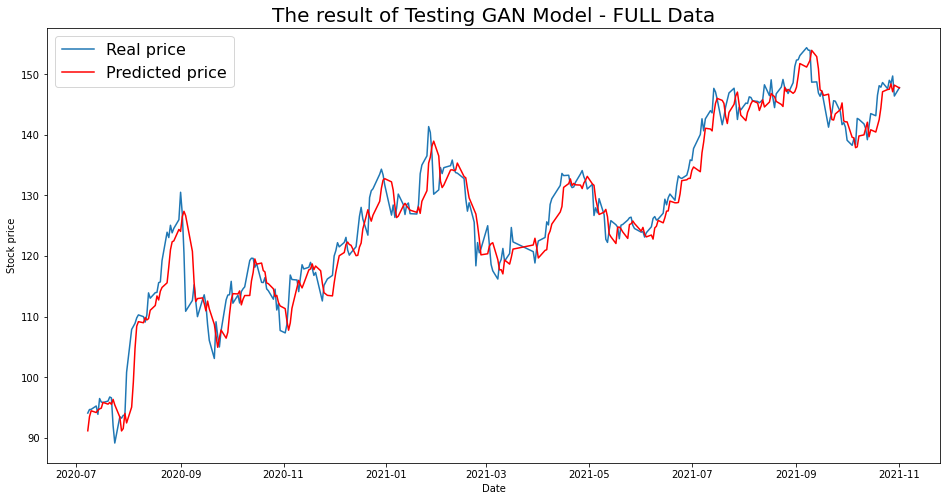

----- test_MSE_GAN ----- 10.315981704167633
----- test_RMSE_GAN ----- 3.2118501995217077
----- test_MAE_GAN ----- 2.4255128503274346


In [ ]:
train_predict_index = np.load("index_train.npy", allow_pickle=True)
test_predict_index = np.load("index_test.npy", allow_pickle=True)

print("----- predicted price -----", Predicted_price)

rescaled_Real_price = y_scaler.inverse_transform(Real_price)
rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

print("----- rescaled predicted price -----", rescaled_Predicted_price)
print("----- SHAPE rescaled predicted price -----", rescaled_Predicted_price.shape)

predict_result = pd.DataFrame()
for i in range(rescaled_Predicted_price.shape[0]):
    y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=index_test[i:i+output_dim])
    predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)
#
real_price = pd.DataFrame()
for i in range(rescaled_Real_price.shape[0]):
    y_test = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=index_test[i:i+output_dim])
    real_price = pd.concat([real_price, y_test], axis=1, sort=False)

predict_result['predicted_mean'] = predict_result.mean(axis=1)
real_price['real_mean'] = real_price.mean(axis=1)

# Plot the predicted result
plt.figure(figsize=(16, 8))
plt.plot(real_price["real_mean"])
plt.plot(predict_result["predicted_mean"], color = 'r')
plt.xlabel("Date")
plt.ylabel("Stock price")
plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
plt.title("The result of Testing GAN Model - FULL Data", fontsize=20)
plt.show()

# Calculate RMSE
predicted = predict_result["predicted_mean"]
real = real_price["real_mean"]
For_MSE = pd.concat([predicted, real], axis = 1)
MSE = (mean_squared_error(predicted, real))
RMSE = np.sqrt(mean_squared_error(predicted, real))
MAE=mae(predicted, real)
print("----- test_MSE_GAN -----", MSE)
print("----- test_RMSE_GAN -----", RMSE)
print("----- test_MAE_GAN -----", MAE)